In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=1000, tau=1e-2, phi=phi, name='d1')
d2 = Population(N=1000, tau=1e-2, phi=phi, name='d2')
pops = np.array([ctx, d1])

# patterns 
S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=114) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_d1 = [GaussianSequence(P,d1.size, seed=29) for i in range(S)]
patterns_d1 = np.stack([s.inputs for s in sequences_d1])
patterns = [patterns_ctx, patterns_d1]

# connectivity probabilities
cp = np.array([[0.05,  0.05], 
               [0.05, 0.05]])
cw = np.array([[0, 0],
               [1, -1]])

Ai1 = np.vstack([[[4,0,0],
                  [0,4,0],
                  [0,0,4]],
                 [[0,0,0],
                  [0,0,0],
                  [0,0,0]]])

Ai2 = np.vstack([[[1,0,0],
                  [0,1,0],
                  [0,0,1]],
                 [[4,0,0],
                  [0,4,0],
                  [0,0,4]]])

A = np.hstack([Ai1, Ai2])

plasticity_rule = np.array([[0, 0],
                          [1, 0]])
J = set_connectivity(pops, cp, cw, A, plasticity_rule, patterns, plasticity)

network = RateNetwork(pops, J, formulation=4, disable_pbar=True)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


In [4]:
# init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
# init_input_d1 = np.random.RandomState().normal(0,1,size=patterns_d1[0][0].shape)

init_input_ctx = phi(patterns_ctx[0][0])
init_input_d1 = phi(patterns_d1[0][1])

T=10 #ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_input_ctx, init_input_d1, 
                          patterns_ctx[0], patterns_d1[0], plasticity, 
                          delta_t=500, eta=0.0005, tau_e=1600, lamb=0.5, 
                          noise1=.13, noise2=.13, etrace=False, hyper=True,
                          r_ext=[lambda t:0, lambda t:1], print_output=False)

INFO:network:Integrating network dynamics


In [5]:
overlaps_ctx = sequences_ctx[0].overlaps(network.pops[0])
overlaps_d1 = sequences_d1[0].overlaps(network.pops[1])
# filename = 'learning-0005-1600-600-5-1000-v0'
# np.savez('./data/' + filename + '.npz', 
#          overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg, 
#          correlations_ctx=correlations_ctx, correlations_bg=correlations_bg, 
#          state_ctx=net_ctx.exc.state, state_bg=net_bg.exc.state)

INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 216.82it/s]
INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 251.70it/s]


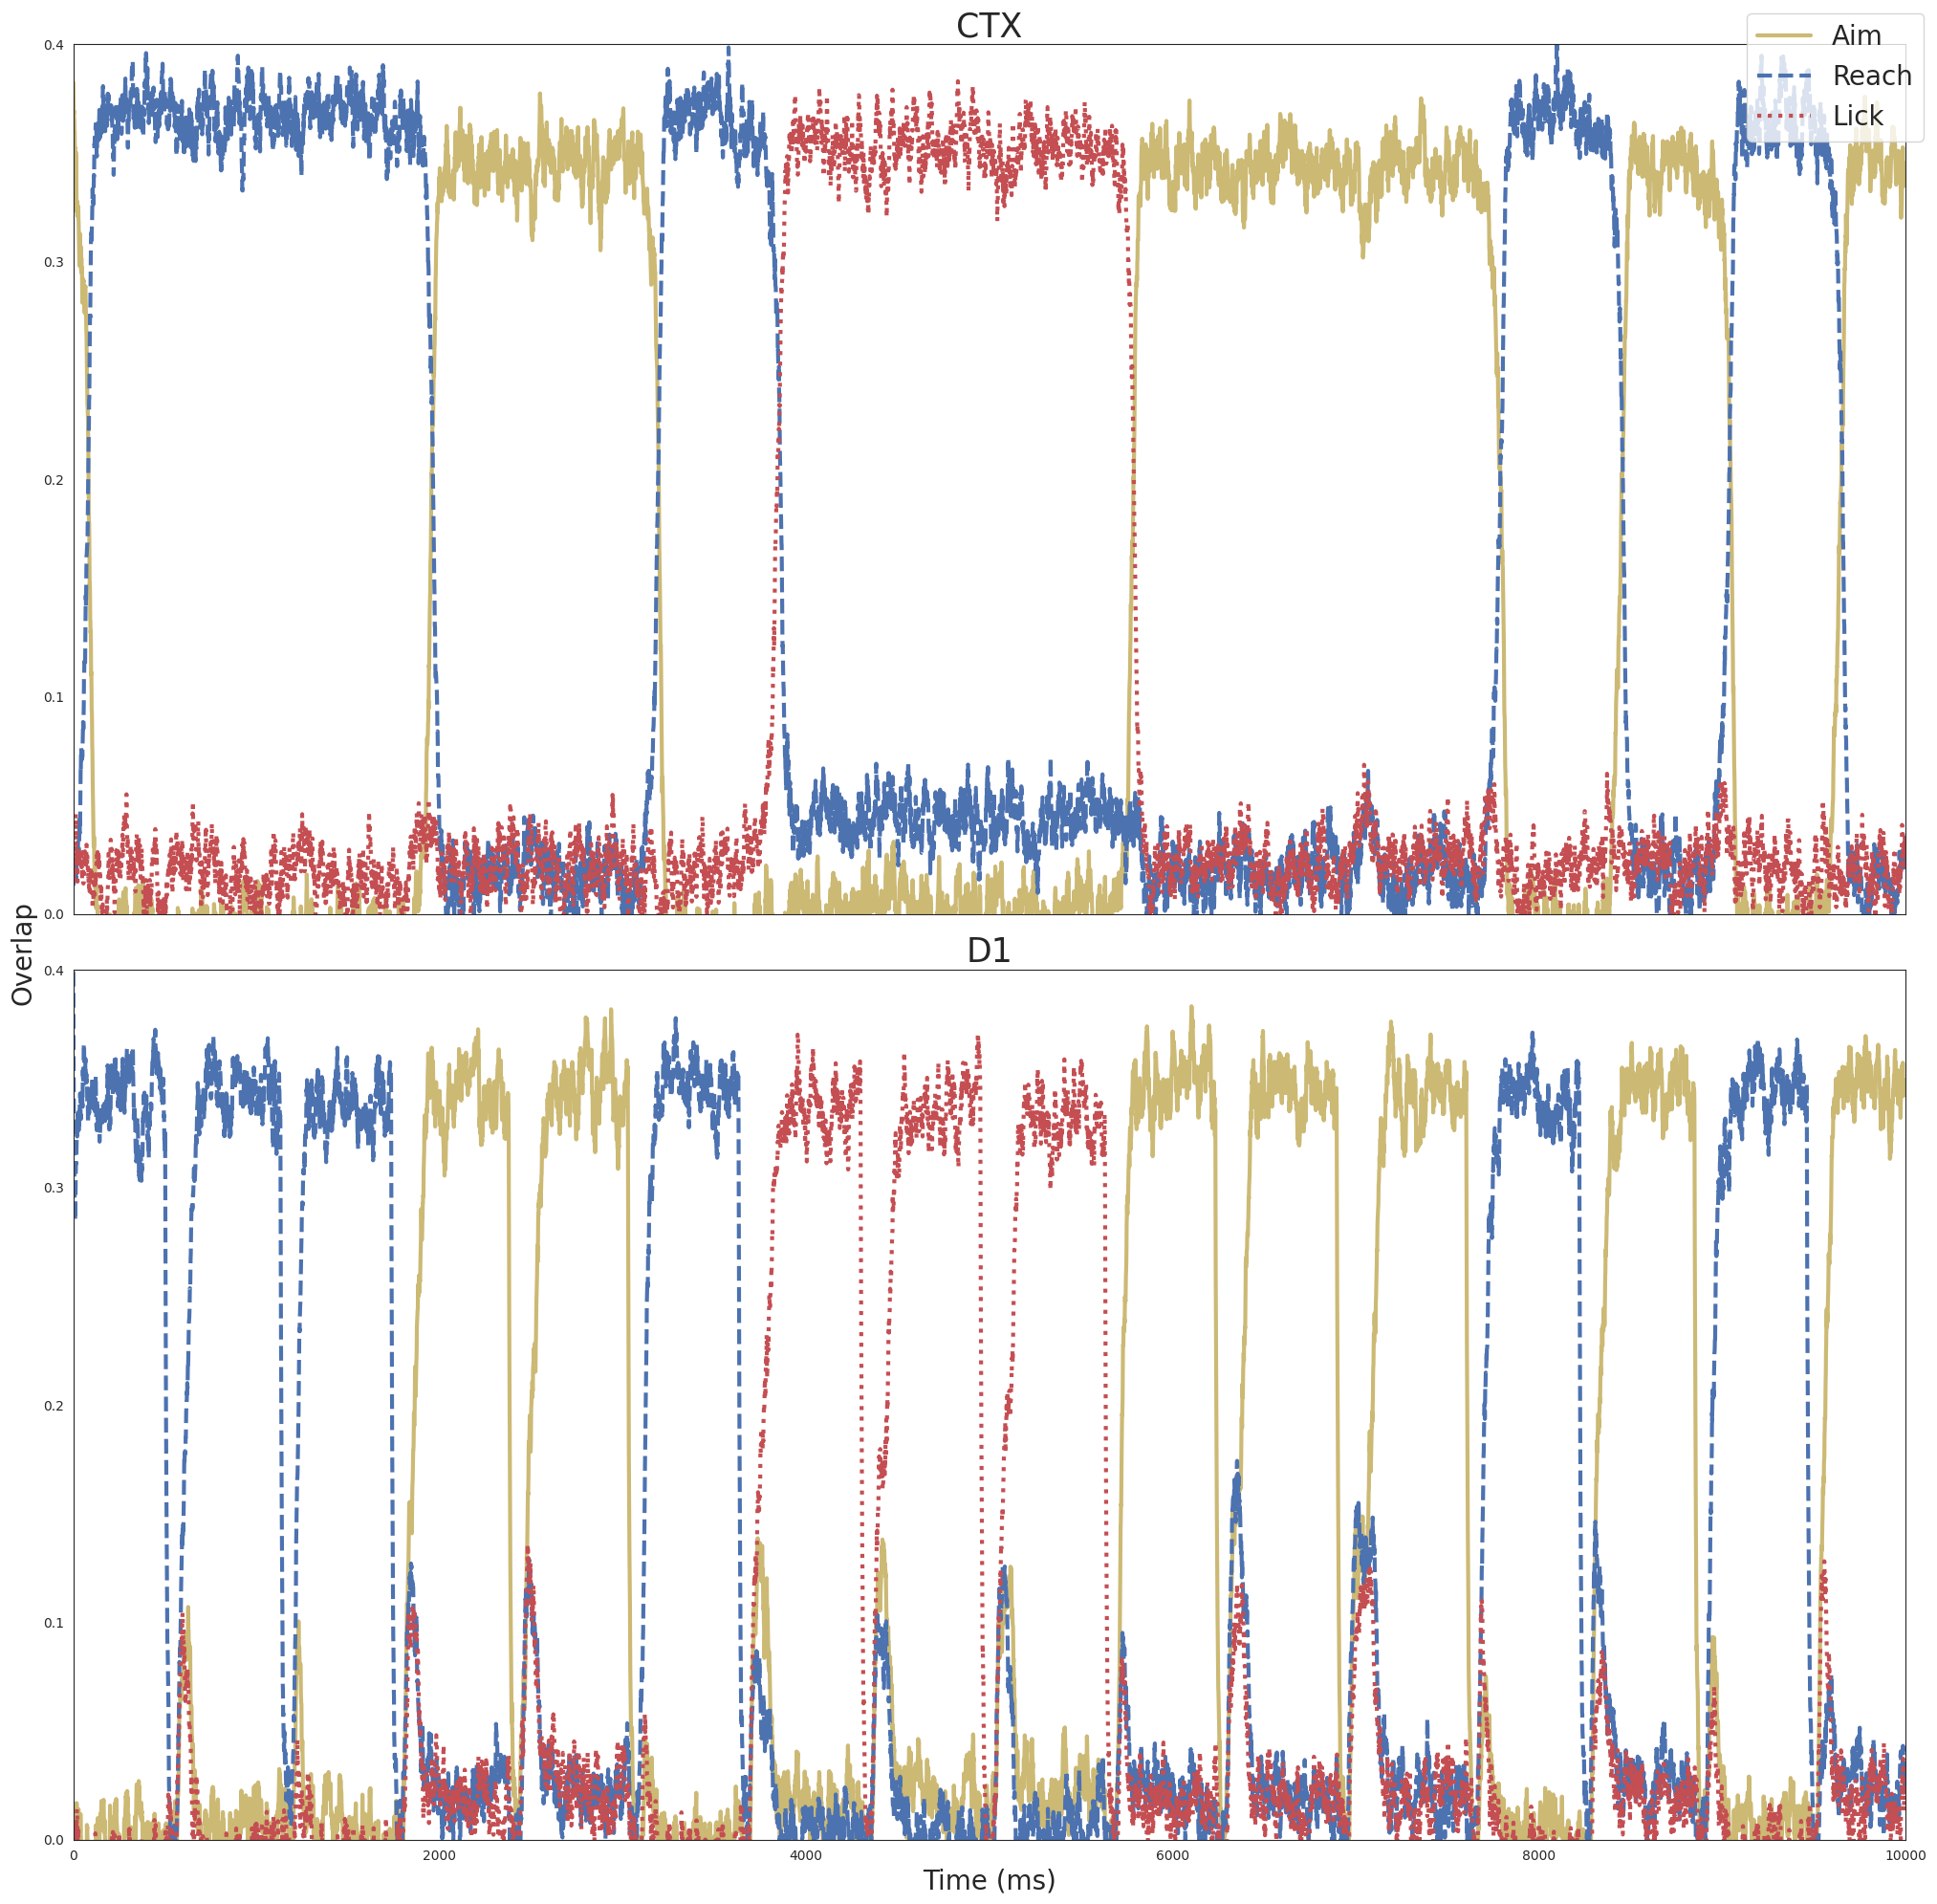

In [7]:
sns.set_style('white') 
colors = sns.color_palette('deep')

fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,20))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 10000))
plt.setp(axes, ylim=(0, 0.4))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/sign.jpg', bbox_inches = "tight", format='jpg')

plt.show()
